In [44]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm

In [45]:
df = pd.read_csv("avocado.csv", header = 0)

In [46]:
df['Date']= pd.to_datetime(df['Date'])

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    18249 non-null  int64         
 1   Date          18249 non-null  datetime64[ns]
 2   AveragePrice  18249 non-null  float64       
 3   Total Volume  18249 non-null  float64       
 4   4046          18249 non-null  float64       
 5   4225          18249 non-null  float64       
 6   4770          18249 non-null  float64       
 7   Total Bags    18249 non-null  float64       
 8   Small Bags    18249 non-null  float64       
 9   Large Bags    18249 non-null  float64       
 10  XLarge Bags   18249 non-null  float64       
 11  type          18249 non-null  object        
 12  year          18249 non-null  int64         
 13  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.9+ MB


In [48]:
avocado = df.set_index('Date')
avocado = avocado.resample('W').sum()

In [49]:
y = avocado['AveragePrice']

In [50]:
y.to_csv("avg_avocado.csv")

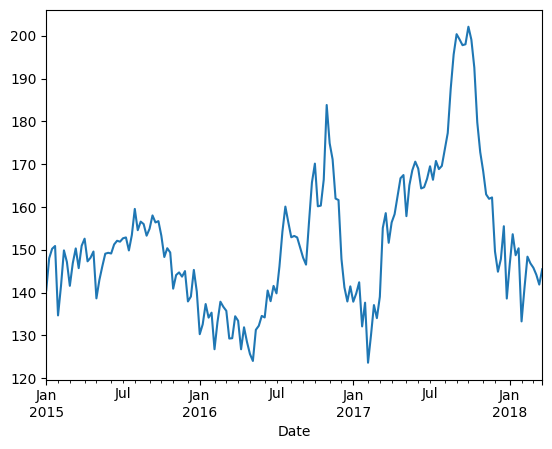

In [51]:
y.plot()
plt.show()

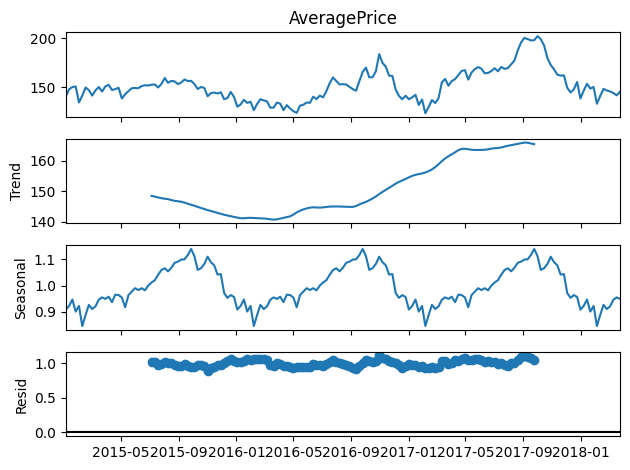

In [52]:
sm.tsa.seasonal_decompose(y, model = 'multiplicative').plot()
plt.show();

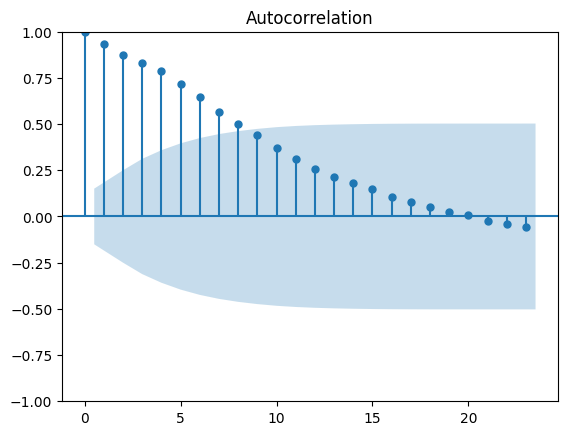

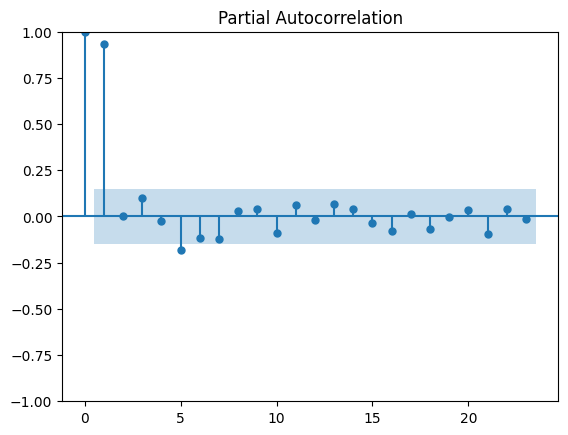

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(y)
pacf_original = plot_pacf(y)

In [54]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(y)
print(f'p-value:{adf_test[1]}')

p-value:0.15226126304825205


<Axes: xlabel='Date'>

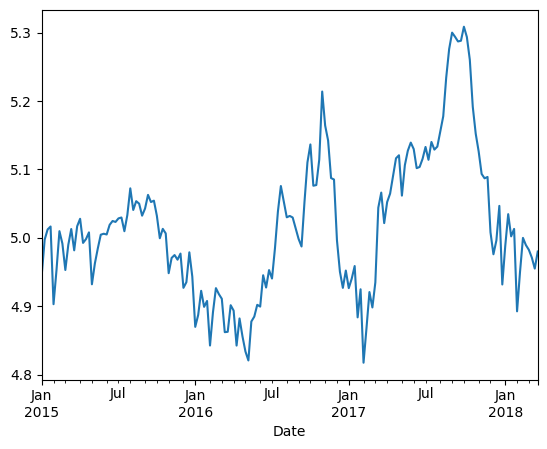

In [55]:
y_log = np.log(y).dropna()
y_log.plot()

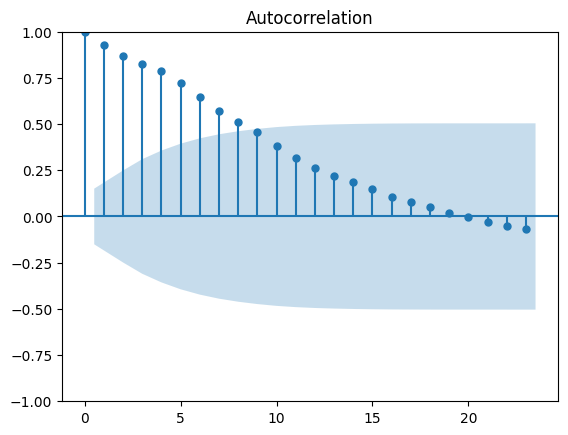

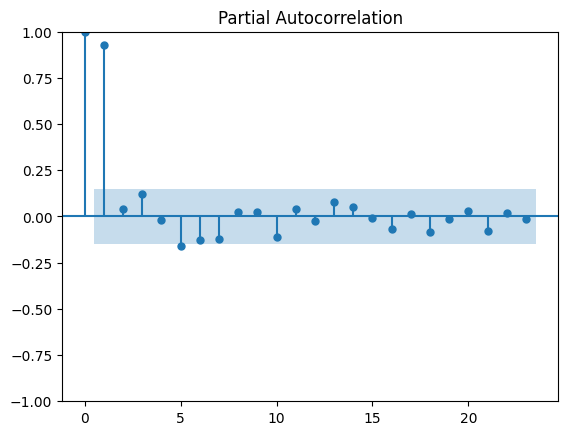

In [56]:
acf_log = plot_acf(y_log)
pacf_log = plot_pacf(y_log)

In [57]:
adf_test_log = adfuller(y_log)
print(f'p-value:{adf_test_log[1]}')

p-value:0.11652087994435534


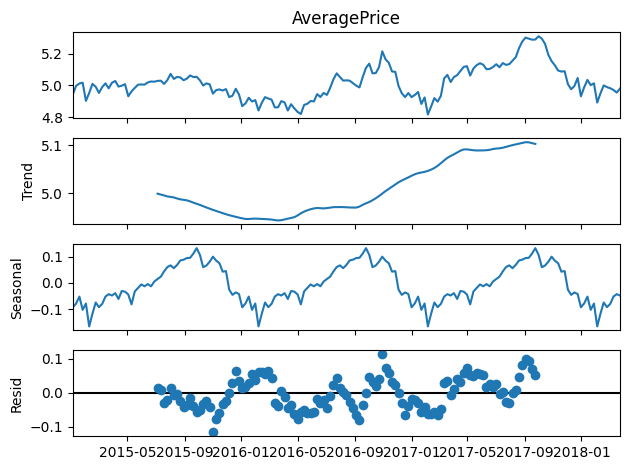

In [58]:
decomposition = sm.tsa.seasonal_decompose(y_log, model='additive')
fig = decomposition.plot()
plt.show()

In [60]:
mod = sm.tsa.statespace.SARIMAX(y_log,
                                order=(1, 1, 2),
                                seasonal_order=(0, 1, 0, 52))
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        AveragePrice   No. Observations:                  169
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 52)   Log Likelihood                 184.923
Date:                             Sun, 23 Jun 2024   AIC                           -361.847
Time:                                     00:35:00   BIC                           -350.832
Sample:                                 01-04-2015   HQIC                          -357.376
                                      - 03-25-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7830      0.164      4.782      0.000       0.462       1.104
ma.L1         -0.7559      

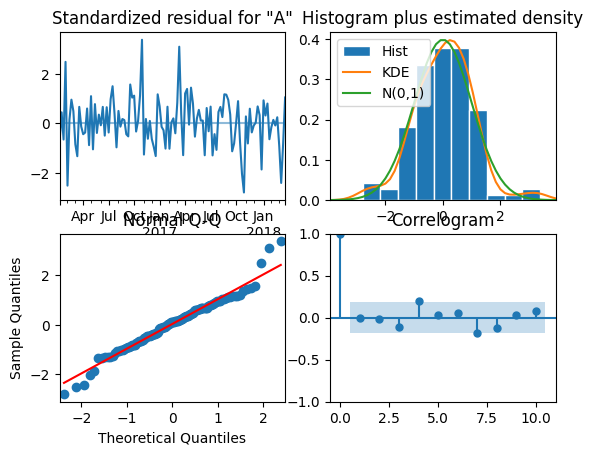

In [61]:
results.plot_diagnostics()
plt.show()

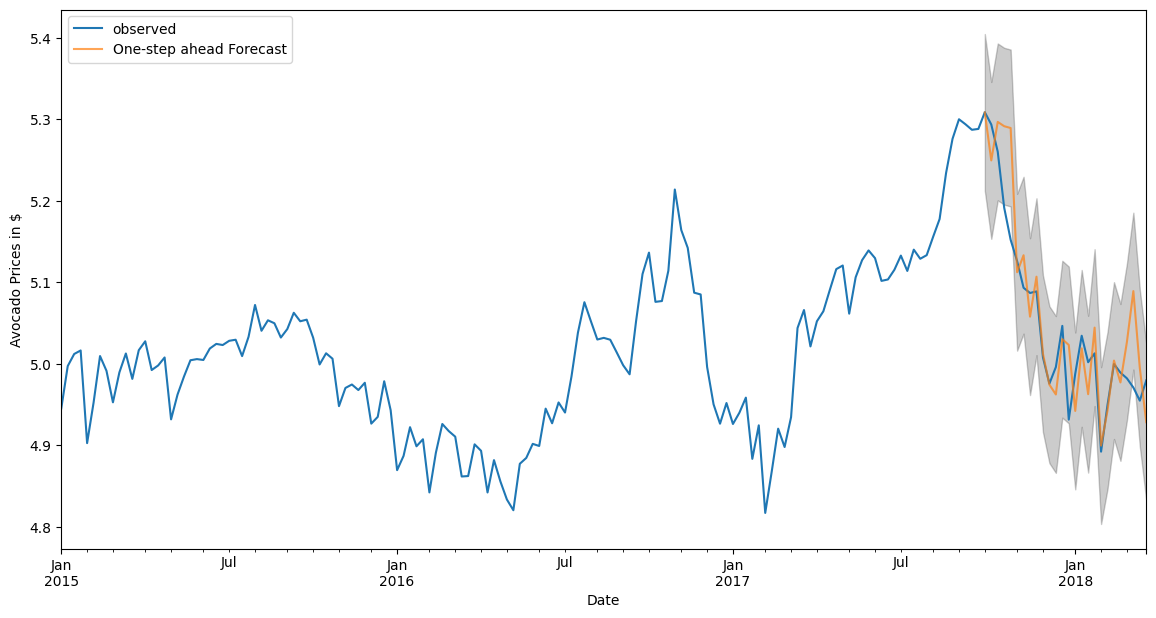

In [62]:
pred = results.get_prediction(start=pd.to_datetime('2017-10-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_log['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Avocado Prices in $')
plt.legend()
plt.show()

In [63]:
y_forecasted = pred.predicted_mean
y_truth = y_log['2017-10-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [64]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.05


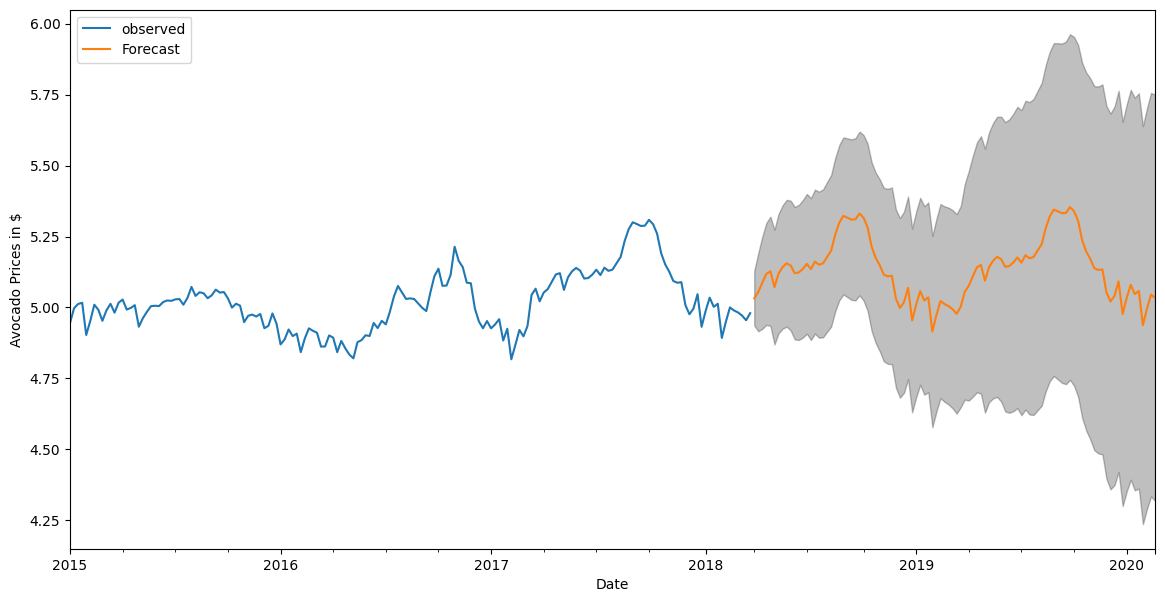

In [65]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y_log.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Avocado Prices in $')
plt.legend()
plt.show()